<a href="https://colab.research.google.com/github/huang12211/SYDE522-InvasivSpecies/blob/main/Copy_of_SYDE522Project_InvasiveSpeciesClassification_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Invasive Species Classifiation

## Setup

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import KFold
from sklearn import metrics
import keras
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras import applications
#from keras.optimizers import Adam
#from keras.optimizers import SGD
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Input, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing import image
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator

from google.colab import files
from google.colab import drive

Using TensorFlow backend.


In [ ]:
#Upload kaggle key (kaggle.json)
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emilylam","key":"20e25f76d25b9a8b9c5746d9e810a39e"}'}

In [ ]:
#Install Kaggle API and download dataset
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c invasive-species-monitoring

 99% 1.13G/1.14G [00:12<00:00, 117MB/s]
100% 1.14G/1.14G [00:12<00:00, 96.1MB/s]
 99% 1.96G/1.98G [00:31<00:00, 142MB/s]
100% 1.98G/1.98G [00:31<00:00, 67.9MB/s]
  0% 0.00/6.19k [00:00<?, ?B/s]
100% 6.19k/6.19k [00:00<00:00, 6.59MB/s]
  0% 0.00/4.18k [00:00<?, ?B/s]
100% 4.18k/4.18k [00:00<00:00, 3.90MB/s]


## Load Data + Preprocessing

### Load training data.

In [ ]:
#Training labels
if os.path.isfile("train_labels.csv") == False:
  !unzip -o train_labels.csv.zip
master = pd.read_csv("train_labels.csv")
master.head()

Archive:  train_labels.csv.zip
  inflating: train_labels.csv        
   creating: __MACOSX/
  inflating: __MACOSX/._train_labels.csv  


,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


In [ ]:
#Training files
if os.path.exists('train') == False:
  !p7zip -d train.7z
img_path = "train/"

y = []
file_paths = []
for i in range(len(master)):
  file_paths.append( img_path + str(master.ix[i][0]) +'.jpg' )
  y.append(master.ix[i][1])
y = np.array(y)


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 2126278821 bytes (2028 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 2126278821
Headers Size = 24792
Method = LZMA2:24
Solid = +
Blocks = 2

  0%      0% 1        0% 4 - train/1000.jpg                         0% 8 - train/1004.jpg                         0% 13 - train/1009.jpg                          0% 14 - train/101.jpg                         0% 17 - train/1012.jpg                          1% 21 - train/1016.jpg

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


In [ ]:
def centering_image(img):
    size = [256,256]

    img_size = img.shape[:2]

    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

In [ ]:
x = []
for i, file_path in enumerate(file_paths):
    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #resize
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))

    #centering
    img = centering_image(cv2.resize(img, dsize=tile_size))

    #out put 224*224px
    img = img[16:240, 16:240]
    x.append(img)

x = np.array(x)

#### Spilt into training and validation data (K-fold setup).

Functions to implement k-fold cross calidation given a model.

In [ ]:
# k=10 found through experimentation to generally result in a model with low bias a modest variance.
kfold_splits = 10

#Initiate the cross validator
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)

### Load testing data.

In [ ]:
if os.path.exists('test') == False:
  !p7zip -d test.7z
img_path = "test/"

if os.path.isfile("sample_submission.csv") == False:
  !unzip -o sample_submission.csv.zip
sample_submission = pd.read_csv("sample_submission.csv")

test_names = []
file_paths = []

for i in range(len(sample_submission)):
    test_names.append(sample_submission.ix[i][0])
    file_paths.append( img_path + str(int(sample_submission.ix[i][0])) +'.jpg' )

test_names = np.array(test_names)

test_images = []
for file_path in file_paths:
    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #resize
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))

    #centering
    img = centering_image(cv2.resize(img, dsize=tile_size))

    #out put 224*224px
    img = img[16:240, 16:240]
    test_images.append(img)

    path, ext = os.path.splitext( os.path.basename(file_paths[0]) )

test_images = np.array(test_images)
test_images = test_images.astype('float32')
test_images /= 255 #normalize


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1227586386 bytes (1171 MiB)

Extracting archive: test.7z
--
Path = test.7z
Type = 7z
Physical Size = 1227586386
Headers Size = 16731
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 6 - test/1002.jpg                        0% 11 - test/1007.jpg                         1% 18 - test/1013.jpg                         1% 27 - test/1021.jpg                         2% 32 - test/1026.jpg                         2% 37 - test/1030.jpg                       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


## VGG16

In [ ]:
# Function to create model
def build_VGG16(input_tensor_shape):
  base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_tensor_shape)
  add_model = Sequential()
  add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
  add_model.add(Dense(256, activation='relu'))
  add_model.add(Dense(1, activation='sigmoid'))

  model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
  model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                metrics=['accuracy'])
  #model.summary()
  return model

In [ ]:
img_rows, img_cols, img_channel = 224, 224, 3
batch_size = 32
epochs = 20
prediction_total = []
prediction_mean = []

Training on fold 1/10...
Epoch 1/20
64/64 [==============================] - 36s 559ms/step - loss: 0.5082 - acc: 0.7441 - val_loss: 0.3298 - val_acc: 0.8609
Epoch 2/20
64/64 [==============================] - 31s 487ms/step - loss: 0.2930 - acc: 0.8712 - val_loss: 0.2934 - val_acc: 0.8696
Epoch 3/20
64/64 [==============================] - 31s 479ms/step - loss: 0.2157 - acc: 0.9161 - val_loss: 0.2157 - val_acc: 0.9130
Epoch 4/20
64/64 [==============================] - 31s 482ms/step - loss: 0.1720 - acc: 0.9347 - val_loss: 0.1297 - val_acc: 0.9609
Epoch 5/20
64/64 [==============================] - 31s 486ms/step - loss: 0.1543 - acc: 0.9473 - val_loss: 0.1096 - val_acc: 0.9609
Epoch 6/20
64/64 [==============================] - 31s 483ms/step - loss: 0.1461 - acc: 0.9473 - val_loss: 0.1056 - val_acc: 0.9652
Epoch 7/20
64/64 [==============================] - 31s 483ms/step - loss: 0.1224 - acc: 0.9541 - val_loss: 0.1223 - val_acc: 0.9565
Epoch 8/20
64/64 [==========================

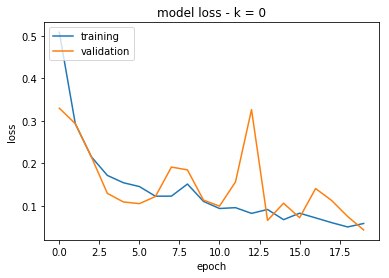

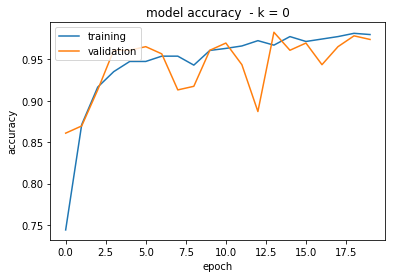

Last training accuracy: 0.9798327594687654, last validation accuracy: 0.9739130434782609
Training on fold 2/10...
Epoch 1/20
64/64 [==============================] - 37s 575ms/step - loss: 0.5490 - acc: 0.7056 - val_loss: 0.3297 - val_acc: 0.8609
Epoch 2/20
64/64 [==============================] - 31s 483ms/step - loss: 0.2787 - acc: 0.8805 - val_loss: 0.1959 - val_acc: 0.9217
Epoch 3/20
64/64 [==============================] - 31s 478ms/step - loss: 0.2084 - acc: 0.9204 - val_loss: 0.1608 - val_acc: 0.9261
Epoch 4/20
64/64 [==============================] - 31s 482ms/step - loss: 0.1852 - acc: 0.9279 - val_loss: 0.1190 - val_acc: 0.9696
Epoch 5/20
64/64 [==============================] - 31s 485ms/step - loss: 0.1687 - acc: 0.9297 - val_loss: 0.1121 - val_acc: 0.9826
Epoch 6/20
64/64 [==============================] - 31s 484ms/step - loss: 0.1330 - acc: 0.9512 - val_loss: 0.1040 - val_acc: 0.9652
Epoch 7/20
64/64 [==============================] - 31s 484ms/step - loss: 0.1390 - acc:

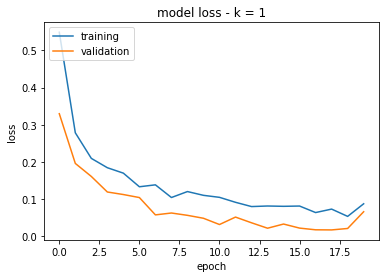

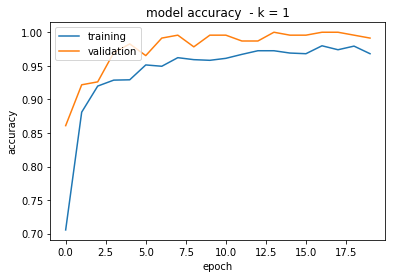

Last training accuracy: 0.9680275455285807, last validation accuracy: 0.9913043473077857
Training on fold 3/10...
Epoch 1/20
64/64 [==============================] - 36s 561ms/step - loss: 0.5559 - acc: 0.6978 - val_loss: 0.3749 - val_acc: 0.8348
Epoch 2/20
64/64 [==============================] - 31s 484ms/step - loss: 0.2811 - acc: 0.8806 - val_loss: 0.2264 - val_acc: 0.9000
Epoch 3/20
64/64 [==============================] - 31s 482ms/step - loss: 0.2247 - acc: 0.9082 - val_loss: 0.1841 - val_acc: 0.9304
Epoch 4/20
64/64 [==============================] - 31s 482ms/step - loss: 0.1759 - acc: 0.9365 - val_loss: 0.1506 - val_acc: 0.9391
Epoch 5/20
64/64 [==============================] - 31s 482ms/step - loss: 0.1683 - acc: 0.9351 - val_loss: 0.1874 - val_acc: 0.9130
Epoch 6/20
64/64 [==============================] - 31s 482ms/step - loss: 0.1489 - acc: 0.9448 - val_loss: 0.1935 - val_acc: 0.9174
Epoch 7/20
64/64 [==============================] - 31s 482ms/step - loss: 0.1376 - acc:

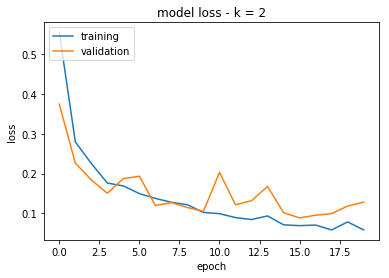

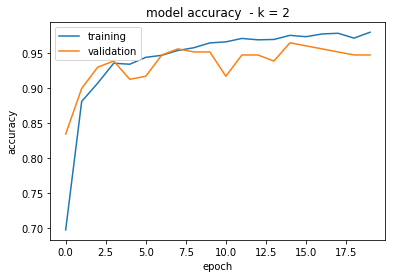

Last training accuracy: 0.9803246434134799, last validation accuracy: 0.9478260869565217
Training on fold 4/10...
Epoch 1/20
64/64 [==============================] - 36s 567ms/step - loss: 0.4970 - acc: 0.7520 - val_loss: 0.2989 - val_acc: 0.8870
Epoch 2/20
64/64 [==============================] - 31s 485ms/step - loss: 0.2641 - acc: 0.8857 - val_loss: 0.1962 - val_acc: 0.9174
Epoch 3/20
64/64 [==============================] - 31s 485ms/step - loss: 0.2112 - acc: 0.9142 - val_loss: 0.1536 - val_acc: 0.9391
Epoch 4/20
64/64 [==============================] - 31s 481ms/step - loss: 0.1704 - acc: 0.9381 - val_loss: 0.1579 - val_acc: 0.9217
Epoch 5/20
64/64 [==============================] - 31s 482ms/step - loss: 0.1716 - acc: 0.9381 - val_loss: 0.1377 - val_acc: 0.9522
Epoch 6/20
64/64 [==============================] - 31s 482ms/step - loss: 0.1642 - acc: 0.9430 - val_loss: 0.1402 - val_acc: 0.9348
Epoch 7/20
64/64 [==============================] - 31s 484ms/step - loss: 0.1273 - acc:

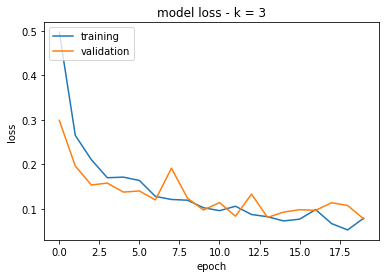

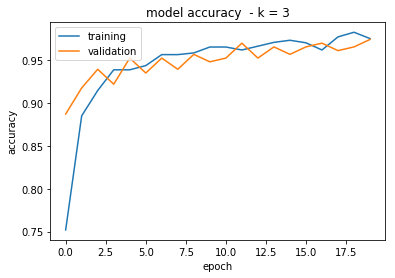

Last training accuracy: 0.9749139203441243, last validation accuracy: 0.9739130429599596
Training on fold 5/10...
Epoch 1/20
64/64 [==============================] - 36s 570ms/step - loss: 0.5175 - acc: 0.7290 - val_loss: 0.2889 - val_acc: 0.9000
Epoch 2/20
64/64 [==============================] - 31s 485ms/step - loss: 0.2672 - acc: 0.8794 - val_loss: 0.2199 - val_acc: 0.9130
Epoch 3/20
64/64 [==============================] - 31s 485ms/step - loss: 0.1956 - acc: 0.9191 - val_loss: 0.2195 - val_acc: 0.9261
Epoch 4/20
58/64 [==========================>...] - ETA: 2s - loss: 0.1728 - acc: 0.9312

In [ ]:
#Run k-fold (k=10) cross-validation

input_tensor_shape=(img_rows, img_cols, img_channel)

# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(x, y)):

    print("Training on fold " + str(index+1) + "/10...")

    # Generate batches from indices
    x_train, x_test = x[train_indices], x[val_indices]
    y_train, y_test = y[train_indices], y[val_indices]

    # Clear model, and create it
    model = None
    model = build_VGG16(input_tensor_shape)

    # Normalize training and validation images
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    #Image transforms
    train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)
    train_datagen.fit(x_train)

    #Train model
    history = model.fit_generator(
      train_datagen.flow(x_train, y_train, batch_size=batch_size),
      steps_per_epoch=x_train.shape[0] // batch_size,
      epochs=epochs,
      validation_data=(x_test, y_test),
      callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)]
    )

    accuracy_history = history.history['acc']
    val_accuracy_history = history.history['val_acc']

    # History for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss - k = ' + str(index) )
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

    # History for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy  - k = ' + str(index))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

    #Run predictions to average later
    predictions = model.predict(test_images)
    prediction_total += predictions

    print("Last training accuracy: " + str(accuracy_history[-1]) + ", last validation accuracy: " + str(val_accuracy_history[-1]))

prediction_mean = prediction_total // kfold_splits

In [ ]:
predictions

array([[9.9063492e-01],
       [8.0922842e-03],
       [2.7073562e-02],
       ...,
       [8.5107435e-04],
       [9.9987137e-01],
       [9.9750596e-01]], dtype=float32)

In [ ]:
#Write to .csv for submission
sample_submission = pd.read_csv("sample_submission.csv")

for i, name in enumerate(test_names):
    sample_submission.loc[sample_submission['name'] == name, 'invasive'] = prediction_mean[i]

sample_submission.to_csv("", index=False)

ValueError: ignored

## ResNet50

In [ ]:
def build_ResNet50(input_tensor_shape):
    '''
    # reference
        https://keras.io/applications/#vgg16
        https://www.tensorflow.org/api_docs/python/tf/contrib/keras/applications/ResNet50
    # model defination
        https://github.com/tensorflow/tensorflow/blob/r1.2/tensorflow/contrib/keras/python/keras/applications/resnet50.py

    # Arguments
        include_top: whether to include the fully-connected layer at the top of the network.

    '''
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape= input_tensor_shape)

    x_model = base_model.output

    x_model = GlobalAveragePooling2D(name='globalaveragepooling2d')(x_model)

    x_model = Dense(1024, activation='relu',name='fc1_Dense')(x_model)
    x_model = Dropout(0.5, name='dropout_1')(x_model)

    x_model = Dense(256, activation='relu',name='fc2_Dense')(x_model)
    x_model = Dropout(0.5, name='dropout_2')(x_model)
    predictions = Dense(1, activation='sigmoid',name='output_layer')(x_model)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [ ]:
img_rows, img_cols, img_channel = 224, 224, 3
batch_size = 32
epochs = 20

## Results

Training/Validation 70/30 Split (no k-fold), previous notebook:
* vgg16_replicated got 0.98411 accuracy
* vgg16_15epochs got 0.98255 in accuracy
* vgg16_20 epochs got 0.98541 accuracy!
* vgg16_25 epochs got 0.98481 accuracy
* Resnet50__5epochs got 0.98741 accuracy!
* Resnet50_3epochs got 0.98710 accuracy


## Resources

* https://www.kaggle.com/jamesrequa/keras-k-fold-inception-v3-1st-place-lb-0-99770
* https://machinelearningmastery.com/k-fold-cross-validation/